# Nuclei segmentation using Cellpose

In this tutorial we show how we can use the anatomical segmentation algorithm Cellpose in `squidpy.im.segment` for nuclei segmentation.

**Cellpose** <cite data-cite="cellpose">Stringer, Carsen, et al. (2021)</cite>, ([code](https://github.com/MouseLand/cellpose)) is a novel anatomical segmentation algorithm. To use it in this example, we need to install it first via: `pip install cellpose`.
To run the notebook locally, create a conda environment as *conda env create -f cellpose_environment.yml* using this [cellpose_environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/envs/cellpose_environment.yml), which installs Squidpy and Cellpose.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import squidpy as sq

## Prepare custom segmentation function using Cellpose

Import the Cellpose segmentation model. See https://cellpose.readthedocs.io/en/latest/api.html#cellpose-class.

In [2]:
from cellpose import models

The method parameter of the `sq.im.segment` method accepts any callable with the signature:
`numpy.ndarray` (height, width, channels) -> `numpy.ndarray` (height, width[, channels]).
Additional model specific arguments will also be passed on.
To use the Cellpose model, we define a wrapper that initializes the model, evaluates it and returns the
segmentation masks. We can make use of Cellpose specific options by passing on arguments like the minimum
number of pixels per mask `min_size`.

In [3]:
def cellpose(img, min_size=15):
    model = models.Cellpose(model_type="nuclei")
    res, _, _, _ = model.eval(
        img,
        channels=[0, 0],
        diameter=None,
        min_size=min_size,
    )
    return res

## Cell segmentation on Visium fluorescence data

Load the image and visualize its channels.

  0%|          | 0.00/303M [00:00<?, ?B/s]

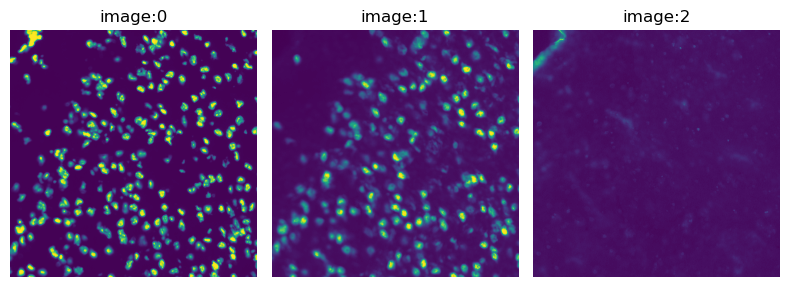

In [4]:
img = sq.datasets.visium_fluo_image_crop()
crop = img.crop_corner(1000, 1000, size=1000)
crop.show(channelwise=True)

Segment the DAPI channel using the `cellpose` function defined above.

In [5]:
sq.im.segment(img=crop, layer="image", channel=0, method=cellpose)

Plot the DAPI channel of the image crop and the segmentation result.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 360


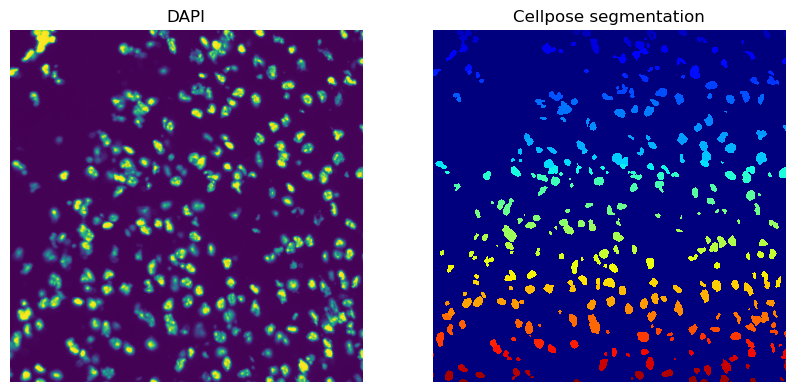

In [6]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

The `sq.im.segment` method will pass any additional arguments to the `cellpose` function, 
so we can also filter out segments with less than 200 pixels and compare the results to the
segmentation result from above that works with the default of 15 pixels.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 221


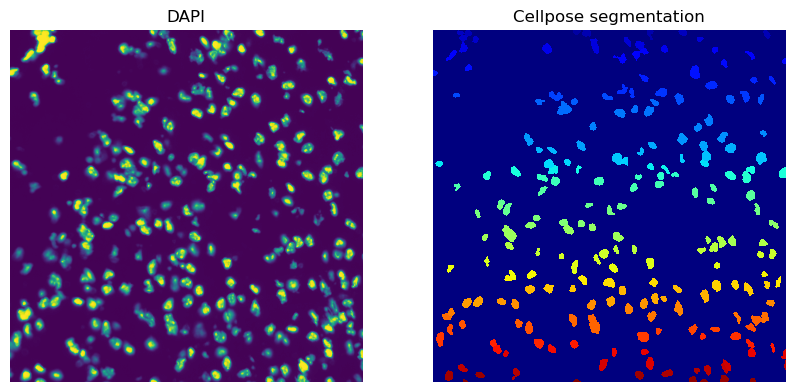

In [7]:
sq.im.segment(img=crop, layer="image", channel=0, method=cellpose, min_size=200)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

## Cell segmentation on H&E stained tissue data

For the fluorescence data, we did nuclei segmentation on the DAPI channel simply by just passing on that channel to the Cellpose model. For the H&E images, we will use the `nuclei` model again. The [`Cellpose` documentation](https://cellpose.readthedocs.io/en/latest/models.html#nucleus-model-nuclei) states:

> The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros. Therefore set the first channel as 0=grayscale, 1=red, 2=green, 3=blue; and set the second channel to zero, e.g. channels = [0,0] if you want to segment nuclei in grayscale or for single channel images, or channels = [3,0] if you want to segment blue nuclei.

Let's look at the image below


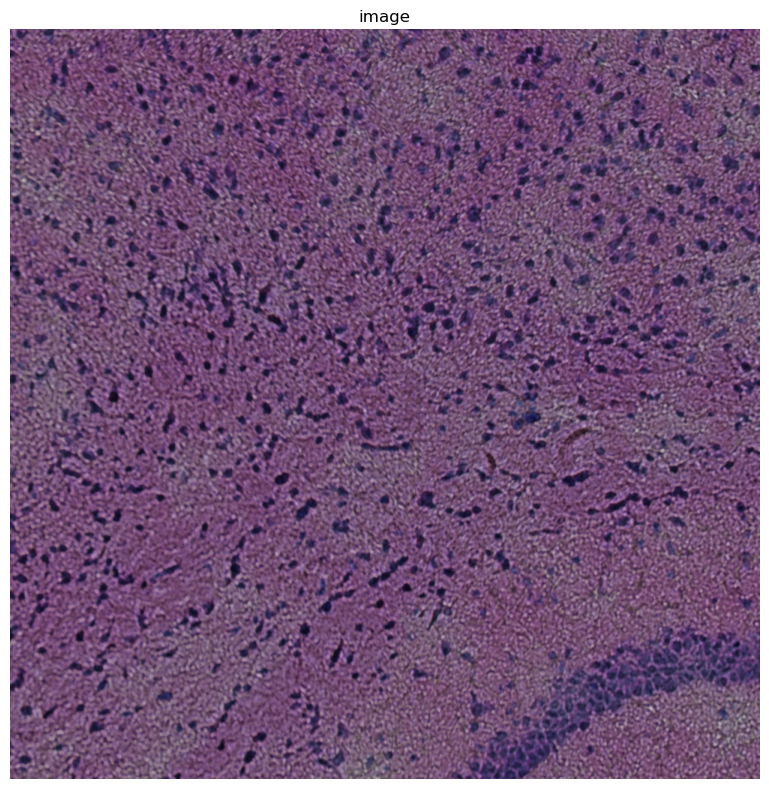

In [16]:
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)
crop.show("image")

The channels below correspond to:
- `image:0` -> red
- `image:1` -> green
- `image:2` -> blue

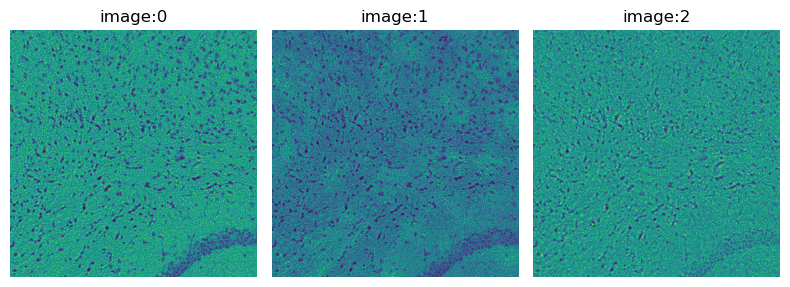

In [23]:
crop.show("image", channelwise=True)

Based on these two images we can suggest two approaches:

A) Due to the H&E staining process, the nuclei seem to have a mostly blue/purple hue, so we could feed the entire H&E image into Cellpose and set the segmentation mode to `blue` (using `3` as the Cellpose channel number)

B) We see above that the red channel (`image:0`) has a particular good contrast, so we could use only that channel and treat it as a greyscale image (using `0` as the Cellpose channel number).

Let's define our custom segmentation function and then try both scenarios. Here, we set the second value in channels to `0` as we will only pass one image. 

In [24]:
def cellpose_he(img, min_size=15, flow_threshold=0.4, channel_cellpose=0):
    model = models.Cellpose(model_type="nuclei")
    res, _, _, _ = model.eval(
        img,
        channels=[channel_cellpose, 0],  # second channel is always 0
        diameter=None,
        min_size=min_size,
        invert=True,
        flow_threshold=flow_threshold,
    )
    return res

Scenario A: All channels as input, Cellpose set to blue (`3`) mode.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 1149


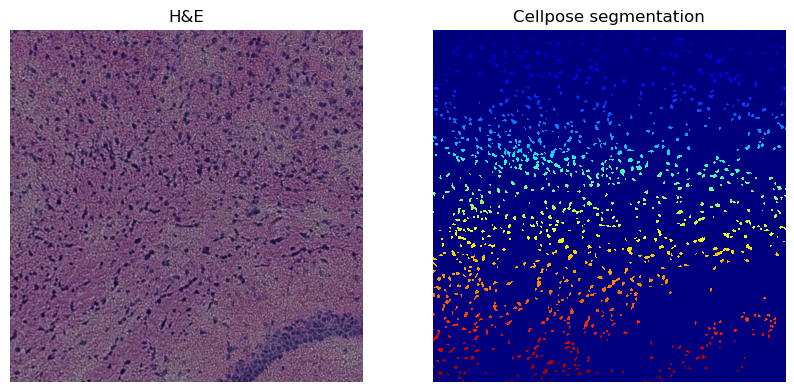

In [26]:
hne_channel_to_segment = None  # so that we feed in all channels
cellpose_channel_setting = 3  # corresponds to "blue"

sq.im.segment(
    img=crop,
    layer="image",
    channel=hne_channel_to_segment,
    method=cellpose_he,
    channel_cellpose=cellpose_channel_setting,
)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=hne_channel_to_segment, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

Scenario B: Only the red channel as input, Cellpose set to greyscale (`0`) mode.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 1630


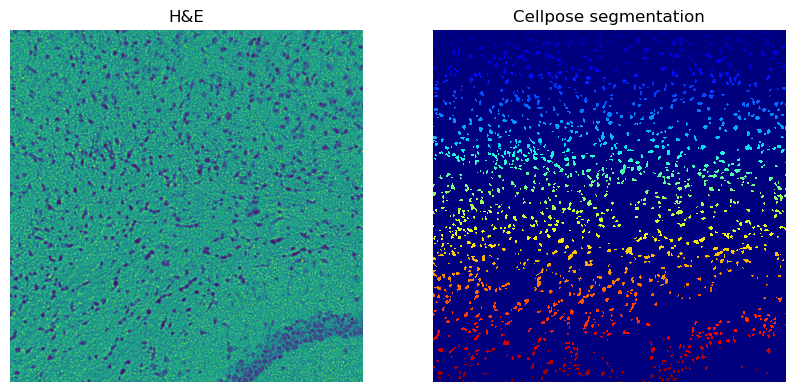

In [ ]:
hne_channel_to_segment = 0  # corresponds to the red channel
cellpose_channel_setting = 0  # corresponds to "greyscale" mode

sq.im.segment(
    img=crop,
    layer="image",
    channel=hne_channel_to_segment,
    method=cellpose_he,
    channel_cellpose=cellpose_channel_setting,
)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=hne_channel_to_segment, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

We see that using only the red channel and treating it as a greyscale yields more cells. Let's further refine this approach by increasing the `flow_threshold=0.8`.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 1767


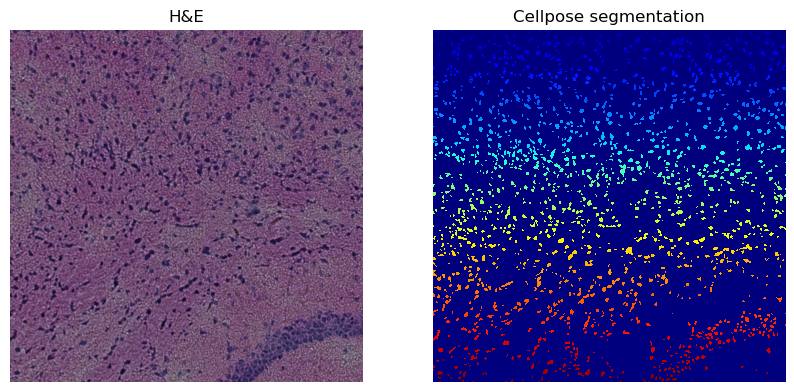

In [28]:
hne_channel_to_segment = 0  # corresponds to the red channel
cellpose_channel_setting = 0  # corresponds to "greyscale" mode

sq.im.segment(
    img=crop,
    layer="image",
    channel=hne_channel_to_segment,
    method=cellpose_he,
    flow_threshold=0.8,
    channel_cellpose=cellpose_channel_setting,
)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=None, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

We see that this further increased the amount of segmented cells.

⚠️ However, it is important to recognise that simply optimising for the number of segmented objects is not the best way to go since at one point this could lead to oversegmentation where cells are being split into two objects or dirt particles or other things are recognised as cells. It is important to analyse the intermediate steps and try out different things.